In [13]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
from rdkit.Chem.MolStandardize import rdMolStandardize

import os.path as osp
import numpy as np
import pandas as pd

import torch
from utils.ionization_group import get_ionization_aid
from utils.descriptor import mol2vec
from utils.net import GCNNet
import py3Dmol

root = osp.abspath("")

def load_model(model_file, device="cpu"):
    model= GCNNet().to(device)
    model.load_state_dict(torch.load(model_file, map_location=device))
    model.eval()
    return model

def model_pred(m2, aid, model, device="cpu"):
    data = mol2vec(m2, aid)
    with torch.no_grad():
        data = data.to(device)
        pKa = model(data)
        pKa = pKa.cpu().numpy()
        pka = pKa[0][0]
    return pka

def predict_acid(mol):
    model_file = osp.join(root, "../models/weight_acid.pth")
    model_acid = load_model(model_file)

    acid_idxs= get_ionization_aid(mol, acid_or_base="acid")
    acid_res = {}
    for aid in acid_idxs:
        apka = model_pred(mol, aid, model_acid)
        acid_res.update({aid:apka})
    return acid_res

def predict_base(mol):
    model_file = osp.join(root, "../models/weight_base.pth")
    model_base = load_model(model_file)

    base_idxs= get_ionization_aid(mol, acid_or_base="base")
    base_res = {}
    for aid in base_idxs:
        bpka = model_pred(mol, aid, model_base) 
        base_res.update({aid:bpka})
    return base_res

def predict(mol, uncharged=True):
    if uncharged:
        un = rdMolStandardize.Uncharger()
        mol = un.uncharge(mol)
        mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol))
    mol = AllChem.AddHs(mol)
    base_dict = predict_base(mol)
    acid_dict = predict_acid(mol)
    AllChem.EmbedMolecule(mol)
    return base_dict, acid_dict, mol

def drawit(m, atom_idxs, pkas, p=None, confId=-1):
    mb = Chem.MolToMolBlock(m, confId=confId)
    if p is None:
        p = py3Dmol.view(width=600, height=400)
    p.removeAllModels()
    p.addModel(mb, 'sdf')
    for pka, idx in zip(pkas, atom_idxs):
        pos = m.GetConformer().GetAtomPosition(idx)
        label = "pKa={:.3}".format(round(pka, 1))
        p.addLabel(label, {"position": {"x": pos.x, "y":pos.y, "z": pos.z}, "fontSize":10})
    p.setStyle({'stick':{'colorscheme':'greenCarbon'}})
    p.setBackgroundColor('0xeeeeee')
    p.zoomTo()
    return p.show()

In [16]:
# mol = Chem.MolFromSmiles("CN(C)CCCN1C2=CC=CC=C2SC2=C1C=C(C=C2)C(C)=O")
mol = Chem.MolFromSmiles("Clc3ccc2nccc(Cn1cccn1)c2c3")
base_dict, acid_dict, m = predict(mol)
atom_idx = list(base_dict.keys()) + list(acid_dict.keys())
pkas = list(base_dict.values()) + list(acid_dict.values())
drawit(m, atom_idx, pkas)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

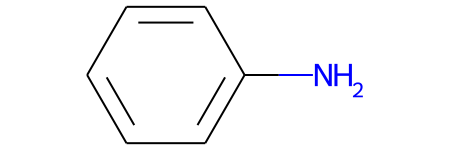

In [9]:
mol